### Methods from previous lab:

In [1]:
import math
import heapq  
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import pandas as pd
from nltk.cluster.util import cosine_distance

In [2]:
# Colors to output with different color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

NDCG calculation from lab 8

In [3]:
#Precision calculation
def calculate_precision(predicted, labeled):
    true_positives = 0
    for e in predicted:
        if e in labeled:
            true_positives += 1
    return true_positives / len(predicted), true_positives

#recall calculation
def calculate_recall(predicted, labeled):
    true_positives = 0
    for e in predicted:
        if e in labeled:
            true_positives += 1
    return true_positives / len(labeled)



def calculate_R(relevance):
    R = {}
    for query_id in relevance:
        ids_and_scores = relevance[query_id]
        for pair in ids_and_scores:
            doc_id = pair[0]
            score = 5 - pair[1]
            R[(query_id, doc_id)] = score
    return R


def NDCG_calculate(r, m):
    numerator = math.pow(2, r) - 1
    denominator = math.log2(1 + m)
    return numerator / denominator


def NDCG(top_k_results, relevance, top_k):
    """
    Computes NDCG score for search results (again chapter 8.4). Here relevance is not considered as binary - the bigger
    the judgement score is, the more relevant is the document to a query. Because in our cranfield dataset relevance
    judgements are presented in a different way (1 is most relevant, 4 is least), we will invert it, replacing each
    score with (5-score). For example, if the score was 2, it becomes 5-2=3.
    To find normalization factor for each query, think in this direction - for this particular query what would be an
    ideal DCG score? What documents should have (ideally) been returned by the search engine to maximize the DCG score?
    When you find it, just normalize the real DCG score by ideal DCG score, that's it.
    :param top_k_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
                          the i-th result corresponds to (i+1)-th query_id. There may be less than top_k
                          results returned for a query, but never more.
    :param relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    :param top_k: (max) number of results retrieved for each query, use this value to find normalization
                  factor for each query
    :return: NDCG score
    """    
    Q = len(relevance)
    R = calculate_R(relevance)
    result = 0
    for q in range(Q):
        query_id = q + 1
        labeled = relevance[query_id]
        predicted = get_predicted_and_labeled(q, top_k_results, relevance)[0]
        # calculate DCG
        dcg = 0
        for m, document_id in enumerate(predicted[:top_k], 1):
            if (query_id, document_id) in R:
                dcg += NDCG_calculate(R[(query_id, document_id)], m)

        # calulating IDCG
        sorted_labeled = sorted(labeled, key=lambda pair: pair[1])  # sort by scores so it simulate ideal situation
        idcg = 0
        for m, document in enumerate(sorted_labeled[:top_k], 1):
            document_id = document[0]
            idcg += NDCG_calculate(R[(query_id, document_id)], m)
        result += dcg / idcg
    return result / Q

Eleven points interpolated average from lab 8

In [4]:
def eleven_points_interpolated_avg(top_k_results, relevance, plot=True):
    """
    Returns 11-points interpolated average over all queries. Refer to chapter 8.4 for explanation.
    First calculate values of precision-recall curve for each query, interpolate them, and average over all queries.
    This function is intended to use when for each query all documents are scored until the last relevant element
    is met. Because we don't usually score each document, instead retrieving only top-k results, we will adapt
    this function. Concretely, if for some query no results are retrieved for some recall level onward
    (e.g. starting with 0.7), then we only count in available values, ignoring the rest. In other words, for each
    recall level we average only over those queries for which precision is available at this recall level.
    Treats relevance judgments as binary - either relevant or not.
    :param top_k_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
                          the i-th result corresponds to (i+1)-th query_id. There may be less than top_k
                          results returned for a query, but never more.
    :param relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    :param plot: whether to plot the graph or not
    :return: interpolated_avg, list of 11 values
    """
    interpolated_avg = []
    Q = len(relevance)
    x = [i / 10 for i in range(11)]  # recall offsets
    all_interpolations = []  # consist of dicts with precision,recalls for each query

    for q in range(Q):
        coordinates = {}  # key -> recall, value->precision
        predicted, labeled = get_predicted_and_labeled(q, top_k_results, relevance)
        chosen_elements = []
        # find coordinates of points (recall, precision)
        for document in predicted:
            chosen_elements.append(document)

            precision_score = calculate_precision(chosen_elements, labeled)[0]
            recall_score = calculate_recall(chosen_elements, labeled)

            if recall_score not in coordinates:
                coordinates[recall_score] = precision_score

        # find interpolation
        interpolated_coordinates = {}
        for i in x:
            right_indexes = [p for p in coordinates if p >= i]
            if len(right_indexes) == 0:
                break
            interpolated_coordinates[i] = max([coordinates[index] for index in right_indexes])  # chooses maximum to the right
        # save all interpolations to find average in future
        all_interpolations.append(interpolated_coordinates)
    # finding average value
    for i in x:
        num_of_precisions = 0
        sum_of_precisions = 0
        for interpolated_coordinates in all_interpolations:
            if(i not in interpolated_coordinates.keys()):
                continue
            sum_of_precisions += interpolated_coordinates[i]
            num_of_precisions += 1
        interpolated_avg.append(sum_of_precisions / num_of_precisions)

    if plot:
        X = np.linspace(0, 1, 11)
        plt.plot(X, interpolated_avg)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.show()

    return interpolated_avg


Mean Average Precision from lab 8

In [5]:
def get_predicted_and_labeled(id, top_k_results, relevance):
    query_id = id + 1
    predicted = top_k_results[id]
    labeled = [e[0] for e in relevance[query_id]]
    return predicted, labeled
def mean_avg_precision(top_k_results, relevance):
    """
    Calculates MAP score for search results, treating relevance judgments as binary - either relevant or not.
    Refer to chapter 8.4 for explanation
    :param top_k_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
                          the i-th result corresponds to (i+1)-th query_id. There may be less than top_k
                          results returned for a query, but never more.
    :param relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    :return: calculated MAP score
    """
    K = len(top_k_results)
    result = 0
    for k in range(K):
        chosen_elements = []
        predicted, labeled = get_predicted_and_labeled(k, top_k_results, relevance)
        precision_score = 0
        for document in predicted:
            chosen_elements.append(document)
            if document in labeled:
                temp_precision_score, relevant_number = calculate_precision(chosen_elements, labeled)
                precision_score += temp_precision_score
        result += 0 if relevant_number == 0 else precision_score / relevant_number
    return result / K


Read data

In [6]:
def read_cranfield(path):
    """
    Helper function, parses Cranfield data. Used for tests. Use it to evaluate your own search engine
    :param path: original data path
    :return: dictionaries - documents, queries, relevance
    relevance comes in form of tuples - query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    """
    documents = {}
    queries = {}
    relevance = {}
    for doc in json.load(open(path + 'cranfield_data.json')):
        documents[doc['id']] = doc['body']
    for query in json.load(open(path + 'cran.qry.json')):
        queries[query['query number']] = query['query']
    for rel in json.load(open(path + 'cranqrel.json')):
        query_id = int(rel['query_num'])
        doc_id = int(rel['id'])
        if query_id in relevance:
            relevance[query_id].append((doc_id, rel['position']))
        else:
            relevance[query_id] = [(doc_id, rel['position'])]
    return documents, queries, relevance

### Part 1. Query Expansion:

Read data:

In [7]:
d, q, relevance = read_cranfield('data/')
del q[0]

Create corpus from documents

In [8]:
corpus_doc = ['']
for doc_id in d:
    doc = d[doc_id]
    corpus_doc.append(doc)

Create corpus from queries

In [9]:
corpus_queries = ['']
for query_id in q:
    query = q[query_id]
    corpus_queries.append(query)

Create vectors:

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
doc_matrix_t = vectorizer.fit_transform(corpus_doc).todense()
query_matrix_t = vectorizer.transform(corpus_queries).todense()

In [12]:
doc_matrix = []
for i in range(len(doc_matrix_t)):
    doc_matrix.append(np.array(doc_matrix_t[i]).reshape(-1,))

query_matrix = []
for i in range(len(query_matrix_t)):
    query_matrix.append(np.array(query_matrix_t[i]).reshape(-1,))


### The Rocchio algorithm for relevance feedback

According to book (Introduction to information retrieval) these are reasonable values
![image.png](attachment:image.png)

In [13]:
#Coefficients 
a = 1
b = 0.75
y = 0.15

Cosine scoring formula:
![image.png](attachment:image.png)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def my_cosine_similarity(a, b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return cos

Modified query formula

![image.png](attachment:image.png)

In [15]:
#fiven D_relevant let's find D nonrelevant
def find_non_relevant(D_relevant, documents):
    res = []
    for doc_id in documents:
            if doc_id not in D_relevant:
                res.append(doc_id)
    return res
#Relevance feedback by Rocchio
def relevance_feedback(queries, documents, relevant):
    modified_queries = {}
    modified_matrix = []
    for query_id in queries:
        #extract query vector
        q0 = query_matrix[query_id]
        #create D relevant
        D_relevant = [e[0] for e in relevant[query_id]]
        #create D nonrelevant
        D_nonrelevant = find_non_relevant(D_relevant,documents)
        
        #calculate sum of relevant vectors
        started = False
        for doc_id in D_relevant:
            if not started:
                sum_of_relevant_vectors = doc_matrix[doc_id].copy()
                started = True
            else:
                sum_of_relevant_vectors += doc_matrix[doc_id]
        
        #calculate sum of non-relevant vectors
        started = False
        for doc_id in D_nonrelevant:
            if not started:
                sum_of_non_relevant_vectors = doc_matrix[doc_id].copy()
                started = True
            else:
                sum_of_non_relevant_vectors += doc_matrix[doc_id]
        # Applying formula
        first_half  = a * q0 + (b/len(D_relevant) * sum_of_relevant_vectors)
        second_half = (y/len(D_nonrelevant)) * sum_of_non_relevant_vectors
        qm = first_half - second_half
        modified_queries[query_id] = qm
        # To avoid null indexes because our query id starts from 1
        if query_id == 1:
            modified_matrix.append(np.zeros(len(qm)))
        modified_matrix.append(qm)
    return modified_queries, modified_matrix

In [16]:
modified_queries, modified_matrix = relevance_feedback(q, d, relevance)

In [17]:
avg = 0
for i in range(1,len(query_matrix)):
    avg += (np.array(cosine_similarity(modified_matrix[i].reshape(1,-1),query_matrix[i].reshape(1,-1))).reshape(-1,)[0])
print(bcolors.BOLD + "Average cosine similarity between initial and after rocchio algorithm vectors :"+ str(avg/(len(query_matrix)-1)) + bcolors.ENDC)

Average cosine similarity between initial and after rocchio algorithm vectors :0.939715788987004


In [18]:
def get_top_k_results(vector, id_t, documents):
    K = len(relevance[id_t])
    results = []
    for doc_id in documents:
        doc_vector = doc_matrix[doc_id].reshape(1, -1)
        results.append((cosine_similarity(vector,doc_vector).reshape(-1,)[0], doc_id))
    sorted_by_score = sorted(results, key=lambda tup: tup[0], reverse=True)
    sorted_by_score = sorted_by_score[:K]
    return [e[1] for e in sorted_by_score], sorted_by_score
#get_top_k_results(1, relevance,d)
old_results = {}
new_results = {}
for query_id in q:
    vector_new = modified_matrix[query_id].reshape(1, -1)
    vector_old = query_matrix[query_id].reshape(1, -1)
    old_results[query_id] = get_top_k_results(vector_old,query_id, d)[0]
    new_results[query_id] = get_top_k_results(vector_new,query_id, d)[0]

In [19]:
top_k_results_new = []
top_k_results_old = []
for i in range(len(q)):
    top_k_results_new.append(new_results[i+1])
    top_k_results_old.append(old_results[i+1])

## Here you can see compared statistics with Rocchio

Mean average precision

In [20]:
print(bcolors.BOLD + str(mean_avg_precision(top_k_results_old,relevance)) +  str(mean_avg_precision(top_k_results_new,relevance)) + bcolors.ENDC )
print(bcolors.BOLD + str(mean_avg_precision(top_k_results_new,relevance) - mean_avg_precision(top_k_results_old,relevance)) + " = improvement with Rocchio"+ bcolors.ENDC)

0.66310610429592260.8910033404042107
0.22789723610828805 = improvement with Rocchio


NDCG scores (number K is equal 30 by tests from previous lav)

In [21]:
print(bcolors.BOLD + str(NDCG(top_k_results_old,relevance,30)) + str(NDCG(top_k_results_new,relevance,30)))
print(NDCG(top_k_results_new,relevance,30) - NDCG(top_k_results_old,relevance,30), "Improvement with Rocchio")


0.45203741532461570.6930290561340531
0.24099164080943736 Improvement with Rocchio


 eleven interpolated points Interpolated

Before Rocchio


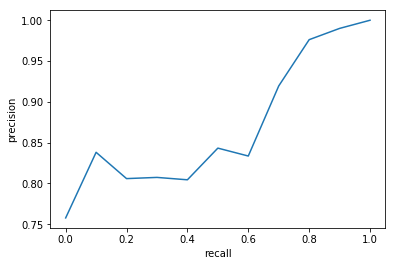

After Rocchio


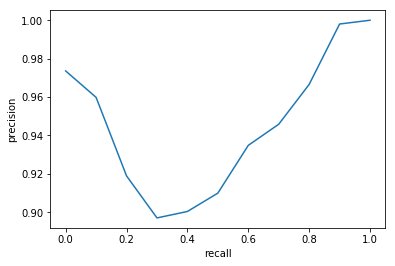

[ 0.2157958   0.12162776  0.11295362  0.08958729  0.09586451  0.0666206
  0.10119686  0.02633146 -0.00961699  0.00803922  0.        ]  = improvement in each region


In [22]:
print(bcolors.BOLD + "Before Rocchio")
before = np.array(eleven_points_interpolated_avg(top_k_results_old,relevance))
print(bcolors.BOLD +"After Rocchio")
after = np.array(eleven_points_interpolated_avg(top_k_results_new,relevance))
print(after - before , " = improvement in each region")

## Pseudo relevance feedback and statistics

In [23]:
pseudo_relevant = {}
for query_id in q:
    top_k = top_k_results_old[query_id-1]
    top_k = [ (i,1) for i in top_k ]
    pseudo_relevant[query_id] = top_k
pseudo_modified_queries, pseudo_modified_matrix = relevance_feedback(q, d, pseudo_relevant)

#get_top_k_results(1, relevance,d)
pseudo_new_results = {}
for query_id in q:
    vector_new = pseudo_modified_matrix[query_id].reshape(1, -1)
    pseudo_new_results[query_id] = get_top_k_results(vector_new,query_id, d)[0]
    
pseudo_top_k_results_new = []
for i in range(len(q)):
    pseudo_top_k_results_new.append(pseudo_new_results[i+1])


In [24]:
avg = 0
for i in range(1,len(query_matrix)):
    avg += (np.array(cosine_similarity(pseudo_modified_matrix[i].reshape(1,-1),query_matrix[i].reshape(1,-1))).reshape(-1,)[0])
print(bcolors.BOLD + "Average cosine similarity between initial and after pseudo algorithm vectors :" + str(avg/(len(query_matrix)-1)))

Average cosine similarity between initial and after pseudo algorithm vectors :0.9476209907692038


In [25]:
print(bcolors.BOLD + "Mean Average Precision")
print(bcolors.BOLD + str(mean_avg_precision(top_k_results_old,relevance)) +  str(mean_avg_precision(pseudo_top_k_results_new,relevance)))
print(mean_avg_precision(pseudo_top_k_results_new,relevance) - mean_avg_precision(top_k_results_old,relevance), " = improvement with Pseudo relevant")

Mean Average Precision
0.66310610429592260.6667813237570793
0.0036752194611566757  = improvement with Pseudo relevant


In [26]:
print(bcolors.BOLD +"NDCG")
print(bcolors.BOLD + str(NDCG(top_k_results_old,relevance,30)) + str(NDCG(pseudo_top_k_results_new,relevance,30)))
print(NDCG(pseudo_top_k_results_new,relevance,30) - NDCG(top_k_results_old,relevance,30), "Improvement with pseudo relevant")

NDCG
0.45203741532461570.4518320111052615
-0.0002054042193542216 Improvement with pseudo relevant


Before Pseudo Relevant


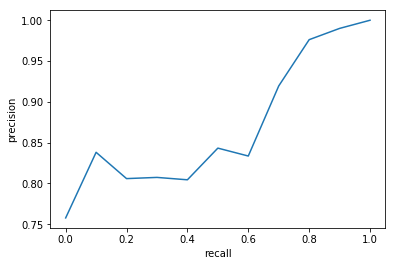

After Pseudo Relevant


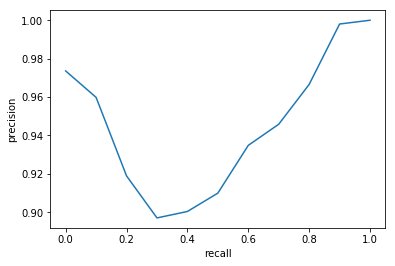

[ 0.2157958   0.12162776  0.11295362  0.08958729  0.09586451  0.0666206
  0.10119686  0.02633146 -0.00961699  0.00803922  0.        ]  = improvement in each region


In [27]:
print(bcolors.BOLD +"Before Pseudo Relevant")
before = np.array(eleven_points_interpolated_avg(top_k_results_old,relevance))
print(bcolors.BOLD +"After Pseudo Relevant")
after = np.array(eleven_points_interpolated_avg(top_k_results_new,relevance))
print(after - before , " = improvement in each region")

## Global method expanding queries by Wordnet by adding synonyms for every token after removing stop words, and lemmatizing

In [28]:
import string
import itertools
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

#NLTK downloads
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Timkabor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Timkabor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Timkabor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Timkabor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag[1].startswith('J'):
        return wordnet.ADJ
    elif treebank_tag[1].startswith('V'):
        return wordnet.VERB
    elif treebank_tag[1].startswith('N'):
        return wordnet.NOUN
    elif treebank_tag[1].startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [30]:
stemmer = SnowballStemmer("english")
query_expansions = {}
for query_id in q:
    
    query = q[query_id]
    #tokenize query
    word_tokens = word_tokenize(query)
        
    #remove stopwords
    filtered_words = [word for word in word_tokens if word not in stopwords.words('english')]
    
    # pos tagging of tokens
    pos = nltk.pos_tag(filtered_words)
    
    # synonyms of tokens
    synonyms = []  
       
    index = 0
    # iterating through the tokens
    for item in filtered_words:
            #synonim sets
            synsets = wordnet.synsets(item)
            if not synsets:
                # stemming the tokens in the query
                synsets = wordnet.synsets(stemmer.stem(item))
            
            # synonyms of the current token
            currentSynonyms = []
            currentPOS = get_wordnet_pos(pos[index])
            
            # iterating through the synsets
            for i in synsets:
                # first we check if token and synset have the same part of speech
                if str(i.pos()) == str(currentPOS):
                    for j in i.lemmas():
                        if j.name() not in currentSynonyms:  # if we have not
                            currentSynonyms.append(j.name().replace("_", " "))
                synonyms.append(currentSynonyms[:2])
            index += 1
            
            # removing duplicate lists in the synonyms list
            tmp = []
            for elem in synonyms:
                if elem and elem not in tmp:
                    tmp.append(elem)
            synonyms = tmp
            
              # now that we have all the synonyms
            s = []
            for x in itertools.product(*synonyms):
                current = ""
                for item in x:
                    current += item
                    current += " "
                s.append(current)
                if(len(s)>4):
                    break
            query_expansions[query_id] = s

# Now we have synonym queries for each of our query           

In [31]:
def get_top_k_results_with_synonyms(id_t, documents):
    synonym_query_matrix_t = vectorizer.transform(query_expansions[id_t]).todense()
    synonym_query_matrix = []
    synonym_vectors = []
    synonym_vectors.append(query_matrix[query_id].reshape(1, -1))
    
    #transform our vector to the shape that built in cosine similarity needs
    for i in range(len(synonym_query_matrix_t)):
        element = np.array(synonym_query_matrix_t[i]).reshape(-1,)
        element_for_cosine_similarity = element.reshape(1, -1)
        synonym_vectors.append(element_for_cosine_similarity)
    # add synonym vectors
    res = []
    for i in synonym_vectors:
        res+= (get_top_k_results(i,id_t,documents)[1])
    # get best synonym vector by score
    res = sorted(res, key=lambda tup: tup[0], reverse=True)
    
    # Filter of repeating vectors from all synonym queries
    used = {}
    final_res = []
    for i in res:
        if(i[1] not in used.keys()):
            used[i[1]] = True
            final_res.append(i[1])
    return final_res[0 : len(relevance[id_t])]

In [32]:
#get_top_k_results(1, relevance,d)
top_k_results_with_synonyms = []
for query_id in q:
    top_k_results_with_synonyms.append(get_top_k_results_with_synonyms(query_id,d))

## Statistics of Global method

In [33]:
print(bcolors.BOLD + "Mean Average Precision")
print(bcolors.BOLD + str(mean_avg_precision(top_k_results_old,relevance)) + str(mean_avg_precision(top_k_results_with_synonyms,relevance)))
print(mean_avg_precision(top_k_results_with_synonyms,relevance) - mean_avg_precision(top_k_results_old,relevance), " = improvement with Global method")

Mean Average Precision
0.66310610429592260.637714249038816
-0.025391855257106632  = improvement with Global method


In [34]:
print(bcolors.BOLD + "NDCG")
print(bcolors.BOLD + str(NDCG(top_k_results_old,relevance,30))+ str(NDCG(top_k_results_with_synonyms,relevance,30)))
print(NDCG(top_k_results_with_synonyms,relevance,30) - NDCG(top_k_results_old,relevance,30), "improvement with Global method")

NDCG
0.45203741532461570.4278542345290069
-0.024183180795608827 improvement with Global method


Before Global


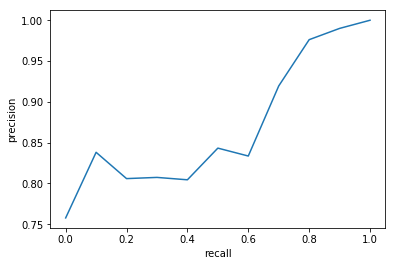

After Global


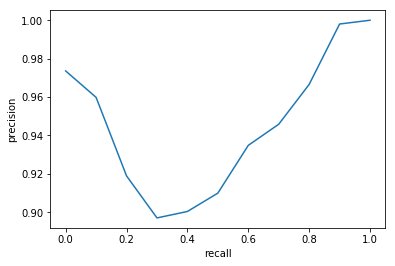

[ 0.2157958   0.12162776  0.11295362  0.08958729  0.09586451  0.0666206
  0.10119686  0.02633146 -0.00961699  0.00803922  0.        ]  = improvement in each region


In [35]:
print(bcolors.BOLD +"Before Global")
before = np.array(eleven_points_interpolated_avg(top_k_results_old,relevance))
print("After Global")
after = np.array(eleven_points_interpolated_avg(top_k_results_new,relevance))
print(after - before , " = improvement in each region")

# Part 2 Document summarization

## First summary method using weights of words

In [36]:
#This function converts document to sentences array
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
stop_words = stopwords.words('english')
#Delete stopwords
def delete_stopwords(sentence):
    result = " ".join([i for i in sentence if i not in stop_words])
    return result
#This function converts document to array of sentences
def convert_document_to_sentences(doc):
    sentences = []
    sentences.append(sent_tokenize(doc)) 
    sentences = [y for x in sentences for y in x]
    clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
    clean_sentences = [a.lower() for a in clean_sentences]
    clean_sentences = [delete_stopwords(r.split()) for r in clean_sentences]
    return sentences

In [37]:
# get dictionary of word counts from document
def get_word_counts(doc):
    count = {}  
    for word in word_tokenize(doc):  
        if word not in stop_words:
            if word not in count.keys():
                count[word] = 1
            else:
                count[word] += 1
    #normalize counts           
    for word in count.keys():  
        count[word] = count[word]/max(count.values())
    return count

In [38]:
#get sentence score using our word counts
def get_sentence_scores(sentences, word_counts):
    result = {}  
    for s in sentences:  
        for word in nltk.word_tokenize(s):
            if word in word_counts.keys():
                if len(s.split(' ')) < 25:
                    if s not in result.keys():
                        result[s] = word_counts[word]
                    else:
                        result[s] += word_counts[word]
    return result

In [39]:
def get_summary_with_weightening(doc, top_k):   
    sentences = convert_document_to_sentences(doc)
    word_counts = get_word_counts(doc)
    sentence_scores = get_sentence_scores(sentences, word_counts)
    summary_sentences = heapq.nlargest(top_k, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)  
    return summary  

In [40]:
def get_summary_results(query_id, summary_function, top_k):
    query = q[query_id]
    print("Your query is " + bcolors.BOLD +  query + bcolors.ENDC)
    index = 1
    for doc_id in top_k_results_new[query_id-1][:top_k]:
        print( bcolors.BOLD +  str(index) + " with doc id = " + str(doc_id) +  " )" + bcolors.ENDC)
        print(summary_function(*(d[doc_id],top_k)))
        index += 1

In [41]:
print(get_summary_results(1,get_summary_with_weightening,5))

Your query is what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .
1 with doc id = 184 )
automatic programmed control of the tunnel would appear to be necessary . experimental and analytical work is required to check on the validity of these assumptions . it is concluded that complete similarity obtains only when aircraft and model are identical in all respects, including size . an investigation is made of the parameters to be satisfied for thermo-aeroelastic similarity . scale models for thermo-aeroelastic research .
2 with doc id = 13 )
the loading on the unheated analog wing is, however, complicated and involves the novel concept of feedback and /body force/ loading . the problem of stressing a heated box-wing structure can be solved by the same analog method and is briefly discussed . similarity laws for stressing heated wings .
3 with doc id = 12 )
methods of attacking and alleviating structural and aeroelastic problems of high-s

## 2nd Summary Method Using Cosine Similarity

In [42]:
def sentence_similarity(sentence_1, sentence_2):
    sentence_1 = sentence_1.replace("[^a-zA-Z]", " ").replace(".","").split(" ")
    sentence_2 = sentence_2.replace("[^a-zA-Z]", " ").replace(".","").split(" ")
    
    union = set(sentence_1 + sentence_2)
    union = list(union)
     
    sentence_vector_1 = []
    for i in range(len(union)):
        sentence_vector_1.append(0)
    sentence_vector_2 = sentence_vector_1.copy()
 
    # build the vector for the first sentence
    for w in sentence_1:
        sentence_vector_1[union.index(w)] += 1
    # build the vector for the second sentence
    for w in sentence_2:
        sentence_vector_2[union.index(w)] += 1

        return  my_cosine_similarity(sentence_vector_1,sentence_vector_2)

def build_similarity_matrix(sentences):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for x in range(len(sentences)):
        for y in range(len(sentences)):
            if x != y: 
                similarity_matrix[x][y] = sentence_similarity(sentences[x], sentences[y])

    return similarity_matrix

In [54]:
def get_summary_with_cosine_similarity(doc,top_k):   
    result = []
    sentences = convert_document_to_sentences(doc)
    sentence_similarity_martix = build_similarity_matrix(sentences)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    
    # apply pagerank algorithm to find scores of sentences
    scores = nx.pagerank(sentence_similarity_graph)
    # try t
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    nx.draw(sentence_similarity_graph)
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    

    for i in range(min(top_k, len(ranked_sentence))):
        result.append("".join(ranked_sentence[i][1]))
    return ". ".join(result)

## Here you can see the example of sentence similarity graoh

'an empirical evaluation of the destalling effects was made for the specific configuration of the experiment .'

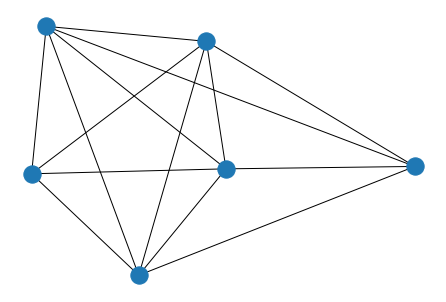

In [55]:
get_summary_with_cosine_similarity(d[1],1)

Your query is what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .
1 with doc id = 184 )
by limiting consideration to conduction effects, by assuming the major load carrying parts of the structure are in regions where the flow is either entirely laminar, or entirely turbulent, and by assuming a specific relationship between reynolds number and nusselt number, an approach to similarity can be achieved for small scale models .. it is concluded that complete similarity obtains only when aircraft and model are identical in all respects, including size .. it appears that existing hot wind tunnels will not be completely adequate for thermo-aeroelastic work, and accordingly a possible layout for the type of tunnel required is described .. scale models for thermo-aeroelastic research .. an investigation is made of the parameters to be satisfied for thermo-aeroelastic similarity .
2 with doc id = 13 )
the problem of stressing a heated box-wing

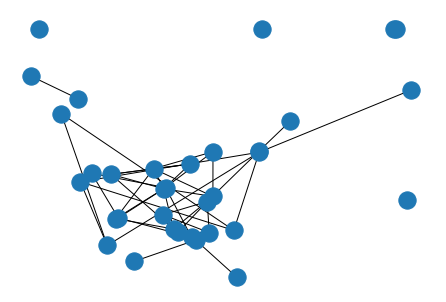

In [62]:
print(get_summary_results(1, get_summary_with_cosine_similarity,5))
